In [1]:
#@title
import torch
from torchvision import transforms as T

import requests # for loading images from web
from PIL import Image, ImageDraw # for viewing images and drawing bounding boxes

from IPython.display import display, Markdown, Latex
from termcolor import colored
import matplotlib.pyplot as plt

In [2]:
model = torch.hub.load('facebookresearch/detr','detr_resnet50',pretrained=True)

if torch.cuda.is_available():
  torch.device('cuda')
  model = model.cuda()

Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 48.6MB/s]
Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cach

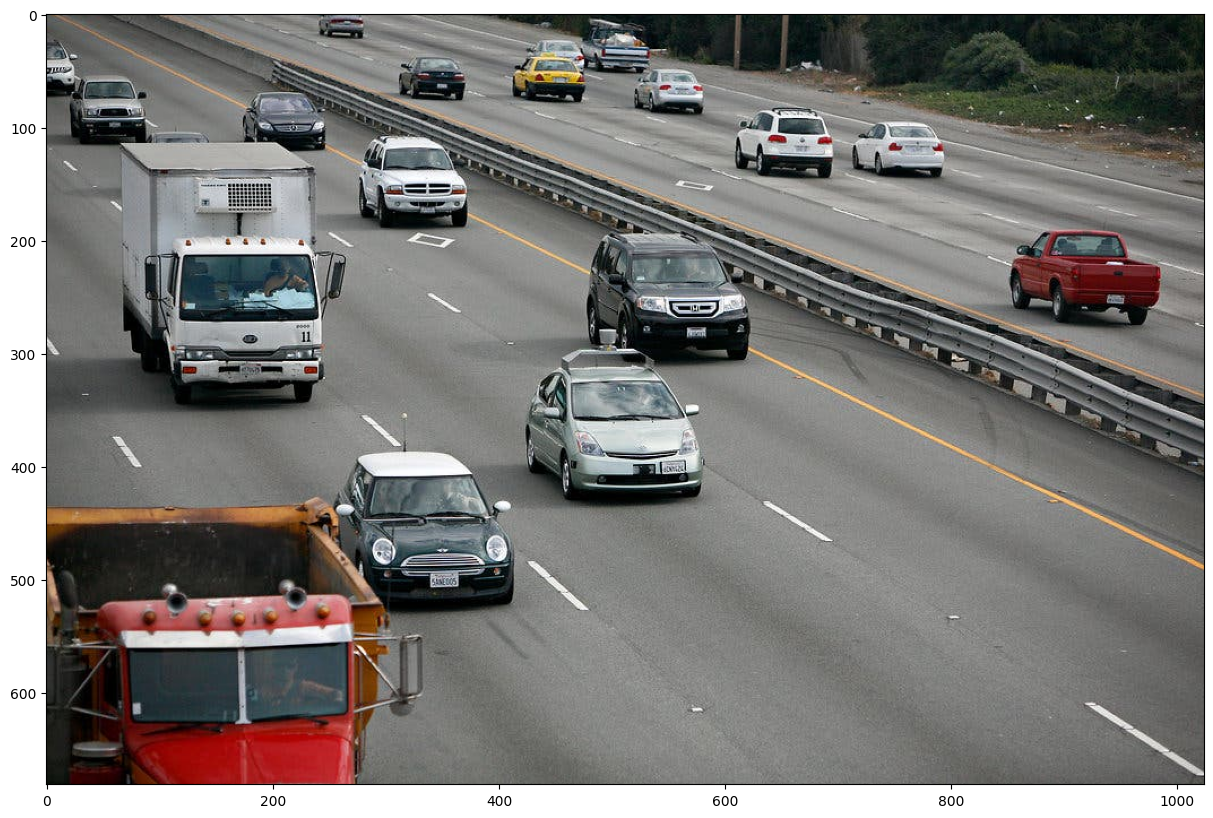

In [3]:
#@title Display Image
# url = "https://i.vimeocdn.com/video/751597323-3057e0a149a649e92a689d23e47342bf322e2390fb87fd6f3c6c3a995126d8ce-d_640?f=webp"
url = "https://static01.nyt.com/images/2010/10/10/us/10google2/10google2-jumbo.jpg?quality=75&auto=webp&disable=upscale"
im = Image.open(requests.get(url, stream=True).raw)
fig = plt.figure(figsize=(15,10))
plt.imshow(im)
plt.show()

In [4]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

img_tensor = transform(im)

In [5]:
# COCO classes
CLASSES = ['N/A', 'Person', 'Bicycle', 'Car', 'Motorcycle', 'Airplane', 'Bus',
           'Train', 'Truck', 'Boat', 'Traffic-Light', 'Fire-Hydrant', 'N/A', 'Stop-Sign',
           'Parking Meter', 'Bench', 'Bird', 'Cat', 'Dog', 'Horse', 'Sheep', 'Cow', 'Elephant',
           'Bear', 'Zebra', 'Giraffe', 'N/A', 'Backpack', 'Umbrella', 'N/A', 'N/A', 'Handbag',
           'Tie', 'Suitcase', 'Frisbee', 'Skis', 'Snowboard', 'Sports-Ball', 'Kite', 'Baseball Bat',
           'Baseball Glove', 'Skateboard', 'Surfboard', 'Tennis Racket', 'Bottle', 'N/A',
           'Wine Glass', 'Cup', 'Fork', 'Knife', 'Spoon', 'Bowl', 'Banana', 'Apple', 'Sandwich',
           'Orange', 'Broccoli', 'Carrot', 'Hot-Dog', 'Pizza', 'Donut', 'Cake', 'Chair', 'Couch',
           'Potted Plant', 'Bed', 'N/A', 'Dining Table', 'N/A','N/A', 'Toilet', 'N/A', 'TV', 'Laptop',
           'Mouse', 'Remote', 'Keyboard', 'Cell-Phone', 'Microwave', 'Oven', 'Toaster',
           'Sink', 'Refrigerator', 'N/A', 'Book', 'Clock', 'Vase', 'Scissors', 'Teddy-Bear',
           'Hair-Dryer', 'Toothbrush']

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [6]:
len(CLASSES)

91

In [7]:
# Get coordinates (x0, y0, x1, y0) from model output (x, y, w, h)
def get_box_coords(boxes):
    x, y, w, h = boxes.unbind(1)
    x0, y0 = (x - 0.5 * w), (y - 0.5 * h)
    x1, y1 = (x + 0.5 * w), (y + 0.5 * h)
    box = [x0, y0, x1, y1]
    return torch.stack(box, dim=1)

In [8]:
# Scale box from [0,1] x [0,1] to [0, width] x [0, height]
def scale_boxes(output_box, width, height):
  box_coords = get_box_coords(output_box)
  scale_tensor = torch.Tensor([width, height, width, height]).to(torch.cuda.current_device())
  return box_coords * scale_tensor

In [9]:
def detect(im, model, transform):
    device = torch.cuda.current_device()
    width = im.size[0]
    height = im.size[1]
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)
    img = img.to(device)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.85

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = scale_boxes(outputs['pred_boxes'][0, keep], width, height)
    return probas[keep], bboxes_scaled

In [10]:
probs, bboxes = detect(im, model, transform)
output=model(img_tensor.unsqueeze(0).to(torch.cuda.current_device()))

In [11]:
output['pred_logits'].size()

torch.Size([1, 100, 92])

In [12]:
def plot_results(pil_img, prob, boxes,labels=True):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for prob, (x0, y0, x1, y1), color in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((x0, y0), x1 - x0, y1 - y0,
                                   fill=False, color=color, linewidth=2))
        cl = prob.argmax()
        text = f'{CLASSES[cl]}: {prob[cl]:0.2f}'
        if labels:
          ax.text(x0, y0, text, fontsize=15,
                bbox=dict(facecolor=color, alpha=0.75))
    plt.axis('off')
    plt.show()

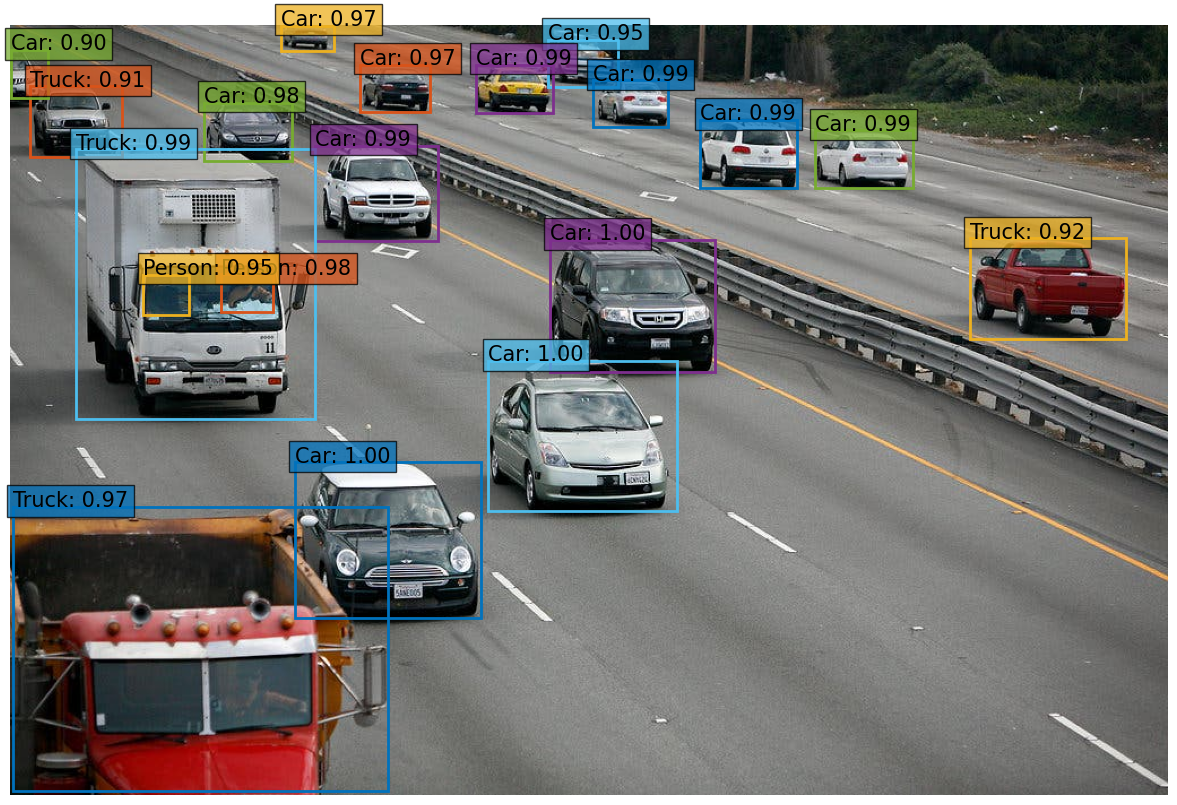

In [13]:
plot_results(im, probs, bboxes)